# ML Project using the BBBP Dataset

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem


from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     cross_val_predict)
from sklearn.metrics import (confusion_matrix, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             precision_recall_curve, 
                             roc_curve, roc_auc_score, 
                             accuracy_score)

### Import Data

In [232]:
# read dataset
bbbp_raw = pd.read_csv("BBBP.csv")
bbbp_raw.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


### Calculate Morgan Fingerprints from SMILES

In [233]:
# suppress warnings from invalid molecules
# for the sake of readability — will deal later
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [234]:
# function to generate canon SMILES
def gen_canon_smiles(smiles_list):
    
    invalid_ids = []
    canon_smiles = []

    for i in range(len(smiles_list)):   
        mol = Chem.MolFromSmiles(smiles_list[i])
        
        # do not append NoneType if invalid
        if mol is None: 
            invalid_ids.append(i)
            continue

        canon_smiles.append(Chem.MolToSmiles(mol))

    return canon_smiles, invalid_ids

In [235]:
# generate canon smiles
canon_smiles, invalid_ids = gen_canon_smiles(bbbp_raw.smiles)

# drop rows with invalid SMILES
bbbp = bbbp_raw.drop(invalid_ids)

# replace SMILES with canon SMILES
bbbp.smiles = canon_smiles

# drop duplicates to prevent train/valid/test contamination
bbbp.drop_duplicates(subset=['smiles'], inplace=True)

In [236]:
# function to calculate morgan fingerprints
def calc_morgan_fpts(smiles_list):
    morgan_fingerprints = []
    
    for i in smiles_list:
        mol = Chem.MolFromSmiles(i)
        
        # do not try to calculate if invalid
        if mol is None: continue
            
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        morgan_fingerprints.append(mfpts) 
        
    return np.array(morgan_fingerprints)

In [237]:
X = calc_morgan_fpts(bbbp.smiles) # -> model features
y = bbbp.p_np # -> model labels

### Split Data into Train/Valid/Test Sets

In [238]:
# set random state
np.random.seed(2023)

# split data into training set and everything else
X_train, X_valid_and_test, y_train, y_valid_and_test = train_test_split(X, y, test_size=0.2, stratify=y)

# split everything else into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_and_test, y_valid_and_test, test_size=0.5, stratify=y_valid_and_test)

train_ratio = round(y_train.size/y.size, 2)
valid_ratio = round(y_valid.size/y.size, 2)
test_ratio = round(y_test.size/y.size, 2)

print(train_ratio, ":", valid_ratio, ":", test_ratio)

0.8 : 0.1 : 0.1


### Develop and Evaluate Models

**training the models**

In [239]:
# SGD Classifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [240]:
# Random Forest Classifier
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)

RandomForestClassifier()

**evaluating the models**

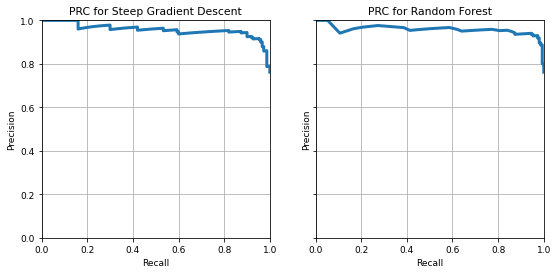

In [275]:
# precision vs. recall curve (PRC)

# calculate precision/recall for SGD
y_scores_sgd = sgd_clf.decision_function(X_valid)
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_valid, y_scores_sgd)

# calculate decision scores for Random Forest
y_probas_forest = forest_clf.predict_proba(X_valid)
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_valid, y_scores_forest)

# plot the precision recall curves for both classifiers
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
axs[0].plot(recalls_sgd, precisions_sgd, linewidth=3)
axs[1].plot(recalls_forest, precisions_forest, linewidth=3)
axs[0].set_xlabel("Recall")
axs[1].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[1].set_ylabel("Precision")
axs[0].grid()
axs[0].axis([0, 1, 0, 1])
axs[0].set_title("PRC for Steep Gradient Descent")
axs[1].grid()
axs[1].axis([0, 1, 0, 1])
axs[1].set_title("PRC for Random Forest")
plt.show()

Based on these graphs, the Random Forest Model seems slightly better at the classification task.

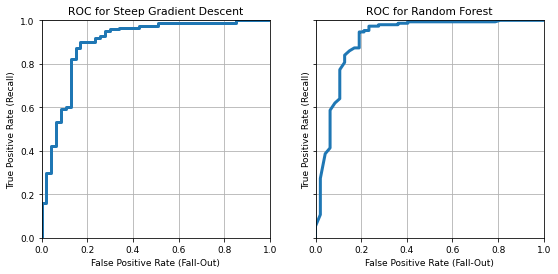

In [276]:
# reciever operating characteristic curve (ROC)

# calculations for SGD
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_valid, y_scores_sgd)

# calculations for Random Forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_valid, y_scores_forest)

# plot the ROC curves for both classifiers
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
axs[0].plot(fpr_sgd, tpr_sgd, linewidth=3)
axs[1].plot(fpr_forest, tpr_forest, linewidth=3)
axs[0].set_xlabel("False Positive Rate (Fall-Out)")
axs[1].set_xlabel("False Positive Rate (Fall-Out)")
axs[0].set_ylabel("True Positive Rate (Recall)")
axs[1].set_ylabel("True Positive Rate (Recall)")
axs[0].grid()
axs[0].axis([0, 1, 0, 1])
axs[0].set_title("ROC for Steep Gradient Descent")
axs[1].grid()
axs[1].axis([0, 1, 0, 1])
axs[1].set_title("ROC for Random Forest")
plt.show()

The graphs look similar at first, but we can calculate the area under the curve (AUC) to compare the two models.

In [277]:
# ROC AOC scores

# SGD classifier
print("SGD ROC-AUC score:", roc_auc_score(y_valid, y_scores_sgd))

# Random Forest classifier
print("Forest ROC-AUC score:", roc_auc_score(y_valid, y_scores_forest))

SGD ROC-AUC score: 0.899290780141844
Forest ROC-AUC score: 0.9157446808510639


The models are very similar in performance, however, the Random Forest Classifier seems to perform slightly better than the SGD Classifier, so we will use the Random Forest Classifier.

**evaluate on the test set**

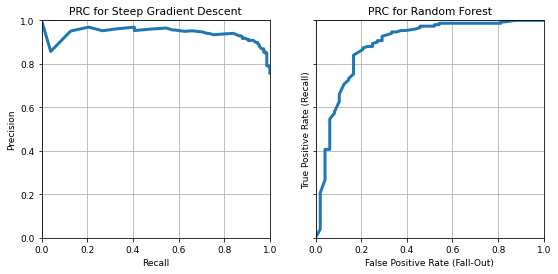

In [270]:
# precision vs. recall curve (PRC)

# calculations for PRC
y_probas_forest = forest_clf.predict_proba(X_test)
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_test, y_scores_forest)

# calculations for ROC
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_scores_forest)

# plot
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
axs[0].plot(recalls_forest, precisions_forest, linewidth=3)
axs[1].plot(fpr_forest, tpr_forest, linewidth=3)
axs[0].set_xlabel("Recall")
axs[1].set_xlabel("False Positive Rate (Fall-Out)")
axs[0].set_ylabel("Precision")
axs[1].set_ylabel("True Positive Rate (Recall)")
axs[0].grid()
axs[0].axis([0, 1, 0, 1])
axs[0].set_title("PRC for Steep Gradient Descent")
axs[1].grid()
axs[1].axis([0, 1, 0, 1])
axs[1].set_title("PRC for Random Forest")
plt.show()

In [273]:
print("Forest ROC-AUC score:", roc_auc_score(y_test, y_scores_forest))

Forest ROC-AUC score: 0.8863194444444443


The model performs slightly worse on the test set, but not by much. Overall, this Random Forest Binary Classifier seems to work pretty well.

### Questions

**Using probability=0.5 as the threshold for the positive label, calculate this model’s accuracy, sensitivity, specificity, precision score, recall score, and F1-score on the training, validation and test sets respectively.**

In [244]:
threshold = 0.5

def sensitivity(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    return cm[0,0]/(cm[0,0]+cm[0,1])

def specificity(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    return cm[1,1]/(cm[1,0]+cm[1,1])

In [245]:
# on the training set
pred_proba = forest_clf.predict_proba(X_train)
pred = (pred_proba [:,1] >= threshold)

print("Training Set:")
print("* accuracy:", accuracy_score(y_train, pred))
print("* sensitivity:", sensitivity(y_train, pred))
print("* specificity:", specificity(y_train, pred))
print("* precision score:", precision_score(y_train, pred))
print("* recall score:", recall_score(y_train, pred))
print("* f1 score:", f1_score(y_train, pred))

Training Set:
* accuracy: 0.9981012658227848
* sensitivity: 0.9920844327176781
* specificity: 1.0
* precision score: 0.9975083056478405
* recall score: 1.0
* f1 score: 0.9987525987525987


In [246]:
# on the validation set
pred_proba = forest_clf.predict_proba(X_valid)
pred = (pred_proba [:,1] >= threshold)

print("Training Set:")
print("* accuracy:", accuracy_score(y_valid, pred))
print("* sensitivity:", sensitivity(y_valid, pred))
print("* specificity:", specificity(y_valid, pred))
print("* precision score:", precision_score(y_valid, pred))
print("* recall score:", recall_score(y_valid, pred))
print("* f1 score:", f1_score(y_valid, pred))

Training Set:
* accuracy: 0.9086294416243654
* sensitivity: 0.6808510638297872
* specificity: 0.98
* precision score: 0.9074074074074074
* recall score: 0.98
* f1 score: 0.9423076923076924


In [247]:
# on the test set
pred_proba = forest_clf.predict_proba(X_test)
pred = (pred_proba [:,1] >= threshold)

print("Training Set:")
print("* accuracy:", accuracy_score(y_test, pred))
print("* sensitivity:", sensitivity(y_test, pred))
print("* specificity:", specificity(y_test, pred))
print("* precision score:", precision_score(y_test, pred))
print("* recall score:", recall_score(y_test, pred))
print("* f1 score:", f1_score(y_test, pred))

Training Set:
* accuracy: 0.8737373737373737
* sensitivity: 0.625
* specificity: 0.9533333333333334
* precision score: 0.8881987577639752
* recall score: 0.9533333333333334
* f1 score: 0.9196141479099679


**What should be the probability threshold for the positive label to choose if you would like to maximize its F1 score performance on the validation set ? At this threshold, what would be this model’s accuracy, sensitivity, specificity, precision score, recall score, and F1-score on the training, validation and test sets respectively.**

The $F_1  \text{score}$ favors classifiers with similar precision and recall. 

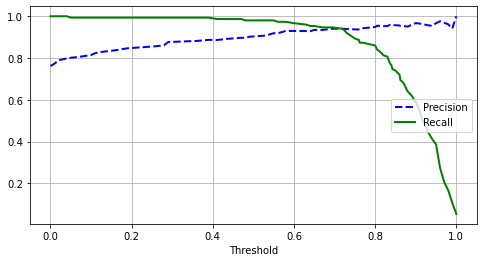

In [248]:
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_scores_forest)

plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

Precision and recall look the most similar at approximately $\text{threshold}=0.7$. If we plot a vertical line for $\text{threshold}=0.7$ we can see:

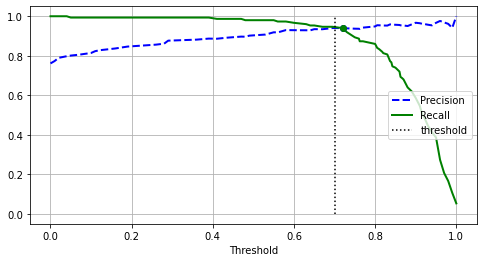

In [249]:
threshold = 0.7
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_scores_forest)

plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")

plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

In [256]:
pred_proba = forest_clf.predict_proba(X_valid)
pred = (pred_proba [:,1] >= threshold)

print("At Threshold = 0.7:")
print("* accuracy:", accuracy_score(y_valid, pred))
print("* sensitivity:", sensitivity(y_valid, pred))
print("* specificity:", specificity(y_valid, pred))
print("* precision score:", precision_score(y_valid, pred))
print("* recall score:", recall_score(y_valid, pred))
print("* f1 score:", f1_score(y_valid, pred))

At Threshold = 0.7:
* accuracy: 0.9086294416243654
* sensitivity: 0.8085106382978723
* specificity: 0.94
* precision score: 0.94
* recall score: 0.94
* f1 score: 0.94


**If you would like to have a machine learning model to have a precision of  50%, what should be the probability threshold for the positive label to choose ?  At this threshold, what would be this model’s accuracy, sensitivity, specificity, precision score, recall score, and F1-score on the training, validation and test sets respectively.**

Search for lowest threshold that gives 50% precision using ```argmax()``` on a numpy array:

In [251]:
idx_for_50_precision = (precisions >= 0.50).argmax()
threshold_for_50_precision = thresholds[idx_for_50_precision]
threshold_for_50_precision

0.0

In [252]:
# on the training set
pred_proba = forest_clf.predict_proba(X_train)
pred = (pred_proba [:,1] >= threshold_for_50_precision)

print("Training Set:")
print("* accuracy:", accuracy_score(y_train, pred))
print("* sensitivity:", sensitivity(y_train, pred))
print("* specificity:", specificity(y_train, pred))
print("* precision score:", precision_score(y_train, pred))
print("* recall score:", recall_score(y_train, pred))
print("* f1 score:", f1_score(y_train, pred))

Training Set:
* accuracy: 0.7601265822784811
* sensitivity: 0.0
* specificity: 1.0
* precision score: 0.7601265822784811
* recall score: 1.0
* f1 score: 0.863718087019058


In [253]:
# on the validation set
pred_proba = forest_clf.predict_proba(X_valid)
pred = (pred_proba [:,1] >= threshold_for_50_precision)

print("Training Set:")
print("* accuracy:", accuracy_score(y_valid, pred))
print("* sensitivity:", sensitivity(y_valid, pred))
print("* specificity:", specificity(y_valid, pred))
print("* precision score:", precision_score(y_valid, pred))
print("* recall score:", recall_score(y_valid, pred))
print("* f1 score:", f1_score(y_valid, pred))

Training Set:
* accuracy: 0.7614213197969543
* sensitivity: 0.0
* specificity: 1.0
* precision score: 0.7614213197969543
* recall score: 1.0
* f1 score: 0.8645533141210375


In [254]:
# on the test set
pred_proba = forest_clf.predict_proba(X_test)
pred = (pred_proba [:,1] >= threshold_for_50_precision)

print("Training Set:")
print("* accuracy:", accuracy_score(y_test, pred))
print("* sensitivity:", sensitivity(y_test, pred))
print("* specificity:", specificity(y_test, pred))
print("* precision score:", precision_score(y_test, pred))
print("* recall score:", recall_score(y_test, pred))
print("* f1 score:", f1_score(y_test, pred))

Training Set:
* accuracy: 0.7575757575757576
* sensitivity: 0.0
* specificity: 1.0
* precision score: 0.7575757575757576
* recall score: 1.0
* f1 score: 0.8620689655172413
